In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px

In [31]:
# laod the V52 data
# skip the first 12 rows

V52_data_raw = pd.read_excel('V52_exel.xlsx', index_col='Date')
# convert the 


In [32]:
# convert the from numeric to datetime
V52_data_raw.index = pd.to_datetime(V52_data_raw.index, format='%Y%m%d%H%M')

c:\Users\enriq\AppData\Local\Programs\Python\Python310\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



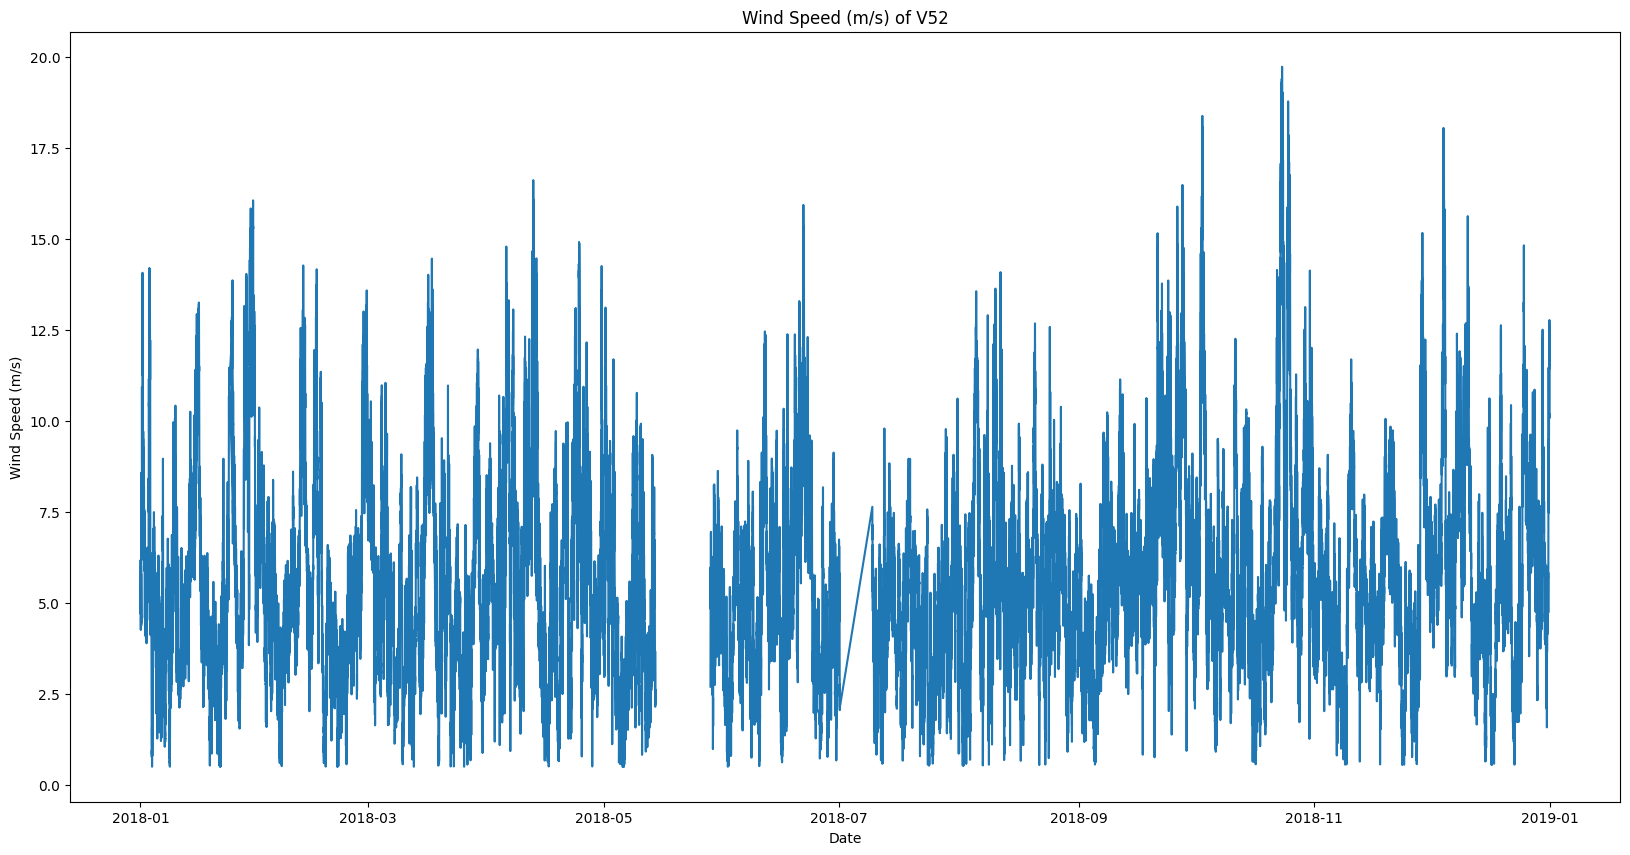

In [33]:

# plot wind speed data with plotly
fig = px.line(V52_data_raw, x=V52_data_raw.index, y='Wsp_44m')
fig.update_layout(title='Wind Speed (m/s) of V52')
fig.show()


#plot using matplotlib
plt.figure(figsize=(20,10))
plt.plot(V52_data_raw.index, V52_data_raw['Wsp_44m'])
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed (m/s) of V52')
plt.show()

